# Learning to Reinforcement Learn with `gymnax`
### [Last Update: December 2022][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/gymnax/blob/main/examples/03_meta_a2c.ipynb)

*Note*: This notebook was partially used to teach at the M2L summer school 2022 in Milano.

In this final exercise we will implement a memory-based meta-reinforcement learning agent. But first what is meta-learning more generally? So far we have trained RL agents to perform a single task (CartPole, etc.) using general-purpose algorithms like temporal difference learning. The neural network executes a policy, which is tailored to the training environment. But what will happen if the environment dynamics change? The agent will most likely not be able to adapt given that the network weights are frozen.

One approach to overcome this limitation is to instead train a network on a distribution of tasks and to explicitly provide the previous reward and action as an input. If the network is an RNN it will be able to adapt its behavior to the incoming information. This can ultimately lead to the discovery of learning algorithms encoded in the network dynamics of the RNN. Hence, by training with RL on many different tasks networks can **learn how to learn and adapt**. Note that there are many different meta-reinforcement learning algorithms and we will only focus on the case of memory-based meta RL simultaneously introduced by [Wang et al. (2016)](https://arxiv.org/abs/1611.05763?source=post_page---------------------------) and [Duan et al. (2016)](https://arxiv.org/abs/1611.02779).

More specifically, we will consider a two arm bandit setting in which the best arm is sampled at the beginning of each episode. In order to perform in every episode the agent has to meta-learn an exploration algorithm, which integrates reward information from the different arms.

Let's start by implementing this simple environment in plain JAX. JAX environments allow us to easily collect data from multiple actors in parallel: We can simply `vmap` over different random number keys. This is especially powerful for distributed actor-critic agents, which rely on efficient on-policy data throughput.

# Installations

In [1]:
!pip install --quiet dm-haiku optax distrax chex gymnax

from IPython.display import clear_output
clear_output()

In [3]:
from typing import NamedTuple, Tuple, Optional

import chex
import distrax
import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import gymnax

import sys
sys.path.append("..")

from my_bernoulli_bandit import MyBernoulliBandit
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define the Bandit Environment

Note that the bandit observation includes the reward $r_{t}$, one-hot encoded action $a_{t}$ as well as a normalized timestep counter $t$. This is ultimately all the information needed for an RNN-based agent to learn which arm is better in a given episode. The parameter `reward_prob` sets the task difficulty. Intuitively, small values will lead to arms with very different expected pull value. Arms which are closer together will be harder to tell apart.

# Define the Meta-Reinforcement Learner LSTM

Next, we will setup a sample actor-critic network with an LSTM module. It is a fairly small model which process the observation inputs and has two output heads: One output policy logits for $\pi(a | h_t)$ and the other outputs a value estimate $v(h_t)$, where $h_t$ denotes the hidden state of the LSTM.

In [22]:
class LSTMMetaRL(hk.RNNCore):
  """Simple LSTM Wrapper with flexible output head."""

  def __init__(
      self,
      num_hidden_units: int = 32,
      num_output_units: int = 2) -> None:
    super().__init__(name="LSTMMetaRL")
    self.num_hidden_units = num_hidden_units
    self.num_output_units = num_output_units

    self._lstm_core = hk.LSTM(self.num_hidden_units)
    self._policy_head = hk.Linear(self.num_output_units)
    self._value_head = hk.Linear(1)

  def initial_state(self, batch_size: int) -> hk.LSTMState:
    return self._lstm_core.initial_state(batch_size)

  def __call__(
      self,
      x: chex.Array,
      state: hk.LSTMState) -> Tuple[hk.LSTMState, chex.Array, chex.Array]:
    output, next_state = self._lstm_core(x, state)
    policy_logits = self._policy_head(output)
    value = self._value_head(output)

    return next_state, policy_logits, value

Instantiate the environment, reset an episode and perform a step. 

In [43]:
env = MyBernoulliBandit()
env_params = env.default_params
rng = jax.random.PRNGKey(0)
obs, state = env.reset(rng, env_params)
next_obs, next_env_state, reward, done, next_arms_tried, info = env.step(rng, state, 1, [0,0], env_params)

# Define A2C Components

In the following the network will be trained using A2C [(Mnih et al., 2016)](http://proceedings.mlr.press/v48/mniha16.pdf). A2C collects data of different workers synchronously (e.g. using a vmapped rollout function) and computes the following objective function:

$$\mathcal{L} = \mathbb{E}_\pi [\log \pi(a | h_t) [R_t - V(h_t)]^\dagger] + \beta_v \mathbb{E}_\pi [(R_t^\dagger - V(h_t))^2] + \beta_e \mathbb{E}_\pi [\mathcal{H}(\pi(a | h_t))],$$

where $\dagger$ denotes stop gradient operation and $R_t = \sum_{i=0}^{T-t-1} \gamma^i r_{t+i}$ is the return to go. It consists of three components:

1. **REINFORCE objective**: $\mathbb{E}_\pi [\log \pi(a | h_t) [R_t - V(h_t)]^\dagger]$. Intuitively, this objective tries to increase the probability of actions that lead to a higher than expected return outcome.
2. **Value estimation**: $\mathbb{E}_\pi [(R_t^\dagger - V(h_t))^2]$. This term tries to improve the capability of the critic to predict the return of following the agents policy.
3. **Entropy regularizer**: $\mathbb{E}_\pi [\mathcal{H}(\pi(a | h_t))]$. The entropy measures the randomness of the policy and can be used to regularize the policy to be more or less exploratory. This plays a key role in discovering learning algorithms or the meta-exploration problem.

Let us now implement a function to rollout the agent and collect the required statistics for computing the objective. We will use `hk.scan` (which is `haiku`'s equivalent of `jax.lax.scan`) in order to ensure that we can jit compile through the episode rollout in a fast manner.

In [38]:
def compute_returns(rewards, gamma=1.):
  """Compute list of returns up to T."""
  R = 0
  returns = jnp.zeros(rewards.shape[0])
  counter = rewards.shape[0] - 1
  for step in reversed(range(len(rewards))):
    R = rewards[step] + gamma * R
    returns = returns.at[counter].set(R)
    counter -= 1
  return returns


def rollout(rng_input, gamma, env_params, steps_in_episode):
  """Rollout a jitted gymnax episode with lax.scan."""
  # Reset the environment
  rng_reset, rng_episode = jax.random.split(rng_input)
  obs, env_state = env.reset(rng_reset, env_params)

  lstm = LSTMMetaRL(48, 2)
  net_state = lstm.initial_state(None)
  arms_tried = jnp.array([0,0])
  def policy_step(state_input, tmp):
      """lax.scan compatible step transition in jax env."""
      obs, env_state, net_state, arms_tried, rng = state_input
      rng, rng_step, rng_act = jax.random.split(rng, 3)
      net_state, logits, value = lstm(obs, net_state)
      policy = distrax.Categorical(logits=logits)
      entropy = policy.entropy()
      action, log_prob = policy.sample_and_log_prob(seed=rng_act, sample_shape=())
      next_obs, next_env_state, reward, done, next_arms_tried, info = env.step(
          rng_step, env_state, action, arms_tried, env_params
      )
      carry = [next_obs, next_env_state, net_state, next_arms_tried, rng]
      return carry, [log_prob, value, entropy, reward, info["real_reward"]]

  # Scan over episode step loop
  _, scan_out = hk.scan(
      policy_step,
      [obs, env_state, net_state, arms_tried, rng_episode],
      (),
      steps_in_episode
  )
  # Unpack episode statistics
  log_probs, values, entropies, rewards, regrets = scan_out
  returns = compute_returns(rewards, gamma)
  advantages = returns - values
  return log_probs, advantages, entropies, jnp.sum(rewards), jnp.sum(regrets)


# Batch rollout helper - vmap over rngs
rollout_fn = hk.without_apply_rng(hk.transform(rollout))
batch_rollout_fn = jax.vmap(rollout_fn.apply, in_axes=(None, 0, None, None, None))

In [49]:
# Rollout an episode and return collected stats
env = MyBernoulliBandit()
env_params = env.default_params

rng = jax.random.PRNGKey(0)
net_params = rollout_fn.init(jax.random.PRNGKey(0), rng, 0.8, env_params, 100)
log_probs, advantages, entropies, reward, regrets = rollout_fn.apply(net_params, rng, 0.8, env_params, 100)

Next up implement the A2C objective function:

In [50]:
def a2c_loss(log_probs, advantages, entropies, entropy_coeff, value_coeff):
  """Compute the actor-critic REINFORCE loss with entropy regularization."""
  # ============ YOUR CODE HERE =============
  actor_loss = -(log_probs * jax.lax.stop_gradient(advantages)).mean()
  critic_loss = (advantages**2).mean()
  entropy_loss = entropies.mean()
  ac_loss = actor_loss + value_coeff*critic_loss - entropy_coeff*entropy_loss
  return ac_loss


@jax.jit
def batch_a2c_loss(net_params, rng_batch, gamma, entropy_coeff, value_coeff, env_params):
  """Batch forward pass for multiple actors & compute average A2C loss."""
  batch_loss_fn = jax.vmap(a2c_loss, in_axes=(0, 0, 0, None, None))
  steps_in_episode = 100
  log_probs, advantages, entropies, rewards, regrets = batch_rollout_fn(net_params, rng_batch, gamma, env_params, steps_in_episode)
  batch_loss = batch_loss_fn(log_probs, advantages, entropies, entropy_coeff, value_coeff)
  return batch_loss.mean(), [jnp.mean(rewards), jnp.mean(regrets)]

In [51]:
# Compute A2C loss for single episode/actor - for beta_v and beta_e
a2c_loss(log_probs, advantages, entropies, 0.1, 0.5)

Array(0.8885231, dtype=float32)

In [52]:
# Compute batch A2C loss for five parallel actors
rng_batch = jax.random.split(rng, 5)
batch_a2c_loss(net_params, rng_batch, 0.8, 0.1, 0.5, env_params)

(Array(0.69423455, dtype=float32),
 [Array(10.36, dtype=float32), Array(49.4, dtype=float32)])

# Run A2C Loop

We are now ready to put everything together into a training loop. Our goal is to reproduce figure 2 f) of the [Wang et al. (2016)](https://arxiv.org/abs/1611.05763?source=post_page---------------------------) paper, which demonstrates the generalization capabilities of the meta-learned bandit RL algorithm to different bandit settings:

In [53]:
def run_a2c_training(rng, env_params, verbose):
  num_updates = 4000
  num_workers = 64
  lr = 0.005
  beta_ent = 1.
  beta_ent_decay = 0.999
  beta_value = 0.5
  gamma = 0.8
  num_ep_steps = 100
  track_loss, track_rewards, track_regrets = [], [], []

  net_params = rollout_fn.init(rng, rng, gamma, env_params, 100)
  optimizer = optax.chain(
        optax.clip_by_global_norm(5.0),
        optax.scale_by_adam(eps=1e-4),
        optax.scale(-0.005),
    )
  opt_state = optimizer.init(net_params)

  for up in range(num_updates):
    # Split random number keys for episode rollout
    rng, rng_b = jax.random.split(rng)
    rng_batch = jax.random.split(rng_b, num_workers)

    # ============ YOUR CODE HERE =============
    # Rollout batch episodes for workers via vmap & perform gradient update
    out, grads = jax.value_and_grad(batch_a2c_loss, has_aux=True)(net_params, rng_batch, gamma, beta_ent, beta_value, env_params)
    updates, opt_state = optimizer.update(grads, opt_state)
    net_params = optax.apply_updates(net_params, updates)
    
    # Decay the exploration loss coefficient - meta-exploration
    beta_ent = jnp.clip(beta_ent * beta_ent_decay, 0.01, 1.0)

    # Track loss and print performance
    track_loss.append(out[0])
    track_rewards.append(out[1][0])
    track_regrets.append(out[1][1])
    if verbose and up % 200 == 0:
      print(f"# Updates: {up} | Loss: {out[0]} | Shaped Return {out[1][0]}  | Real Return: {out[1][1]} | b_e: {beta_ent}")
  return net_params, track_loss, track_rewards, track_regrets

In [54]:
net_params_10, loss_10, rewards_10, regrets_10 = run_a2c_training(rng, env_params, verbose=True)

# Updates: 0 | Loss: 0.10988835990428925 | Shaped Return 10.884374618530273  | Real Return: 50.125 | b_e: 0.9990000128746033
# Updates: 200 | Loss: -0.22606801986694336 | Shaped Return 25.29999542236328  | Real Return: 64.515625 | b_e: 0.8178321719169617
# Updates: 400 | Loss: -0.08384761214256287 | Shaped Return 30.88749885559082  | Real Return: 69.984375 | b_e: 0.6695191860198975
# Updates: 600 | Loss: -0.06282252818346024 | Shaped Return 33.49687194824219  | Real Return: 72.640625 | b_e: 0.5481024384498596
# Updates: 800 | Loss: 0.02998652681708336 | Shaped Return 37.16874694824219  | Real Return: 76.21875 | b_e: 0.4487048387527466
# Updates: 1000 | Loss: 0.08422094583511353 | Shaped Return 41.09062194824219  | Real Return: 79.984375 | b_e: 0.3673325479030609
# Updates: 1200 | Loss: 0.12099802494049072 | Shaped Return 42.38749694824219  | Real Return: 81.265625 | b_e: 0.3007172644138336
# Updates: 1400 | Loss: 0.23451970517635345 | Shaped Return 47.40312194824219  | Real Return: 85.

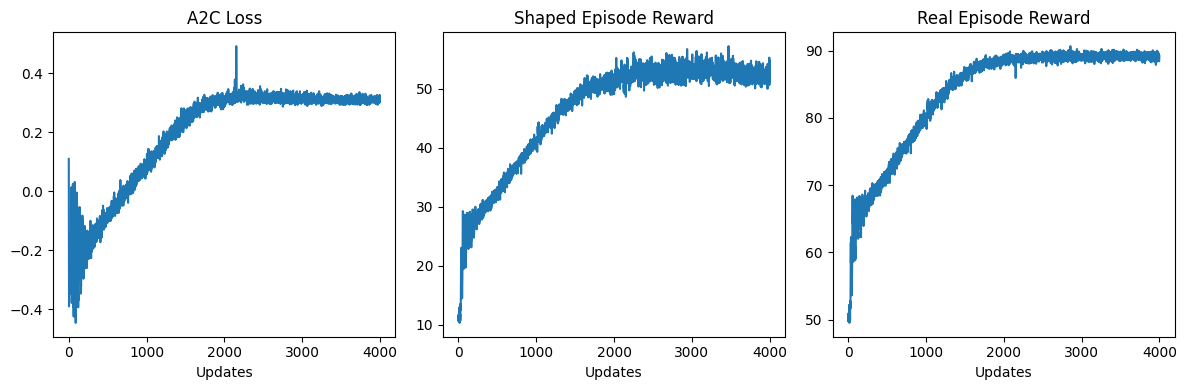

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_10)
axs[0].set_title("A2C Loss")
axs[1].plot(rewards_10)
axs[1].set_title("Shaped Episode Reward")
axs[2].plot(regrets_10)
axs[2].set_title("Real Episode Reward")

for i in range(3):
  axs[i].set_xlabel("Updates")
fig.tight_layout()

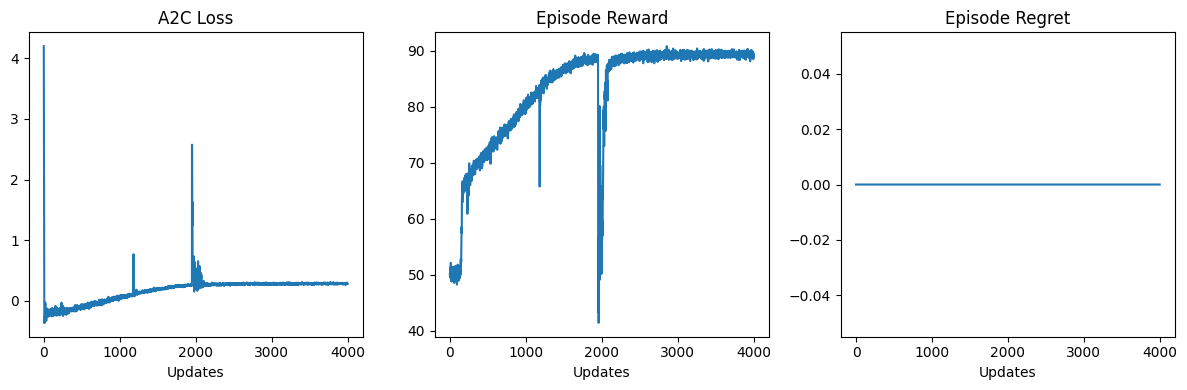

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_10)
axs[0].set_title("A2C Loss")
axs[1].plot(rewards_10)
axs[1].set_title("Episode Reward")
axs[2].plot(regrets_10)
axs[2].set_title("Episode Regret")

for i in range(3):
  axs[i].set_xlabel("Updates")
fig.tight_layout()

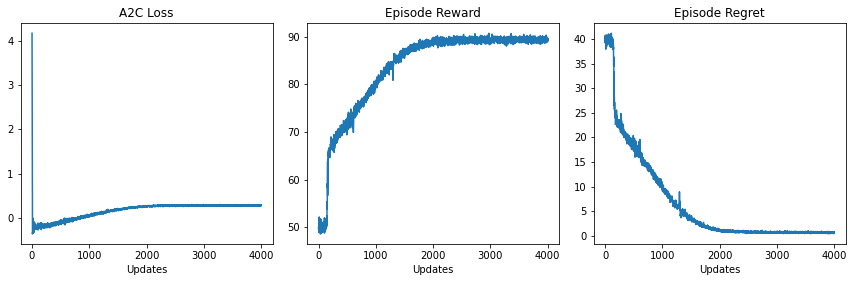

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_10)
axs[0].set_title("A2C Loss")
axs[1].plot(rewards_10)
axs[1].set_title("Episode Reward")
axs[2].plot(regrets_10)
axs[2].set_title("Episode Regret")

for i in range(3):
  axs[i].set_xlabel("Updates")
fig.tight_layout()

# Evaluate Generalization

Next, we can take the network checkpoint trained on the easy bandit task (0.1 `reward_prob`) and test how it performs on harder tasks:

In [14]:
env_params_10 = EnvParams(reward_prob=0.1)
env_params_25 = EnvParams(reward_prob=0.25)
env_params_40 = EnvParams(reward_prob=0.4)

rng_batch = jax.random.split(rng, 64)
_, _, _, _, regret_10_10 = batch_rollout_fn(net_params_10, rng_batch, 0.8, env_params_10, 100)
_, _, _, _, regret_10_25 = batch_rollout_fn(net_params_10, rng_batch, 0.8, env_params_25, 100)
_, _, _, _, regret_10_40 = batch_rollout_fn(net_params_10, rng_batch, 0.8, env_params_40, 100)

regret_10_10.mean(), regret_10_25.mean(), regret_10_40.mean()

(DeviceArray(0.6875, dtype=float32),
 DeviceArray(1.140625, dtype=float32),
 DeviceArray(3.5968752, dtype=float32))

Even though the meta-learner was not trained on hard bandit tasks, its meta-learning exploration algorithm is capable of generalizing to the unseen setting. Let's now train agents on harder bandit tasks:

In [15]:
net_params_25, loss_25, rewards_25, regrets_25 = run_a2c_training(rng, env_params_25, verbose=True)

_, _, _, _, regret_25_10 = batch_rollout_fn(net_params_25, rng_batch, 0.9, env_params_10, 100)
_, _, _, _, regret_25_25 = batch_rollout_fn(net_params_25, rng_batch, 0.9, env_params_25, 100)
_, _, _, _, regret_25_40 = batch_rollout_fn(net_params_25, rng_batch, 0.9, env_params_40, 100)

regret_25_10.mean(), regret_25_25.mean(), regret_25_40.mean()

# Updates: 0 | Loss: 4.183656215667725 | Return 49.75  | Regret: 25.0390625 | b_e: 0.9990000128746033
# Updates: 200 | Loss: -0.1636858582496643 | Return 50.265625  | Regret: 25.125 | b_e: 0.8178321719169617
# Updates: 400 | Loss: -0.07612765580415726 | Return 57.40625  | Regret: 17.421875 | b_e: 0.6695191860198975
# Updates: 600 | Loss: -0.0006994768045842648 | Return 60.234375  | Regret: 15.28125 | b_e: 0.5481024384498596
# Updates: 800 | Loss: 0.05531803518533707 | Return 61.46875  | Regret: 14.234375 | b_e: 0.4487048387527466
# Updates: 1000 | Loss: 0.07975044846534729 | Return 63.0625  | Regret: 11.875 | b_e: 0.3673325479030609
# Updates: 1200 | Loss: 0.13205844163894653 | Return 65.234375  | Regret: 10.2734375 | b_e: 0.3007172644138336
# Updates: 1400 | Loss: 0.2039772868156433 | Return 67.859375  | Regret: 7.0703125 | b_e: 0.2461823672056198
# Updates: 1600 | Loss: 0.21568433940410614 | Return 69.75  | Regret: 5.453125 | b_e: 0.20153741538524628
# Updates: 1800 | Loss: 0.2601448

(DeviceArray(0.9624999, dtype=float32),
 DeviceArray(1.2421875, dtype=float32),
 DeviceArray(2.3500004, dtype=float32))

In [16]:
net_params_40, loss_40, rewards_40, regrets_40 = run_a2c_training(rng, env_params_40, verbose=True)

_, _, _, _, regret_40_10 = batch_rollout_fn(net_params_40, rng_batch, 0.95, env_params_10, 100)
_, _, _, _, regret_40_25 = batch_rollout_fn(net_params_40, rng_batch, 0.95, env_params_25, 100)
_, _, _, _, regret_40_40 = batch_rollout_fn(net_params_40, rng_batch, 0.95, env_params_40, 100)

regret_40_10.mean(), regret_40_25.mean(), regret_40_40.mean()

# Updates: 0 | Loss: 4.186663627624512 | Return 49.8125  | Regret: 10.009376525878906 | b_e: 0.9990000128746033
# Updates: 200 | Loss: -0.15455523133277893 | Return 50.984375  | Regret: 10.05312728881836 | b_e: 0.8178321719169617
# Updates: 400 | Loss: -0.03203165903687477 | Return 50.015625  | Regret: 10.00625228881836 | b_e: 0.6695191860198975
# Updates: 600 | Loss: 0.10917842388153076 | Return 50.359375  | Regret: 9.850001335144043 | b_e: 0.5481024384498596
# Updates: 800 | Loss: 0.0710330531001091 | Return 49.875  | Regret: 10.212502479553223 | b_e: 0.4487048387527466
# Updates: 1000 | Loss: 0.12697479128837585 | Return 48.84375  | Regret: 10.212501525878906 | b_e: 0.3673325479030609
# Updates: 1200 | Loss: 0.19187688827514648 | Return 50.734375  | Regret: 9.987502098083496 | b_e: 0.3007172644138336
# Updates: 1400 | Loss: 0.2452111542224884 | Return 52.359375  | Regret: 8.06875228881836 | b_e: 0.2461823672056198
# Updates: 1600 | Loss: 0.23364955186843872 | Return 53.453125  | Reg

(DeviceArray(1.1499999, dtype=float32),
 DeviceArray(1.28125, dtype=float32),
 DeviceArray(2.0656252, dtype=float32))

Text(0.5, 1.0, 'Wang et al. F2f) - Cumulative Regret')

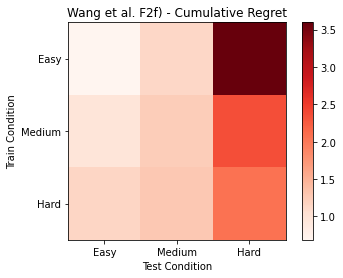

In [17]:
results = jnp.array([[regret_10_10.mean(), regret_10_25.mean(), regret_10_40.mean()],
                     [regret_25_10.mean(), regret_25_25.mean(), regret_25_40.mean()],
                     [regret_40_10.mean(), regret_40_25.mean(), regret_40_40.mean()]])

fig, ax = plt.subplots()
img = ax.imshow(results, cmap='Reds')

label_list = ['Easy', 'Medium', 'Hard']
ax.set_xticks([0.0, 1.0, 2.0])
ax.set_xticklabels(label_list)
ax.set_xlabel('Test Condition')

ax.set_yticks([0.0, 1.0, 2.0])
ax.set_yticklabels(label_list)
ax.set_ylabel('Train Condition')
fig.colorbar(img)
ax.set_title("Wang et al. F2f) - Cumulative Regret")